# Sentiment and Collocation Analysis of COVID-19 Tweets: Unveiling Variations in Sentiment and Major Topics in the U.S. during Early 2020

## Introduction
During times of the COVID-19 pandemic, Twitter has emerged as a powerful medium for individuals to share their real-time thoughts, concerns, and experiences. Analyzing the sentiments expressed and collocation emerged in tweets in specific time ranges can provide valuable insights and situation-consciousness by examining prevailing public emotions and topics. In this study, we aim to conduct sentiment and collocation analysis on a dataset of tweets related to COVID-19, which included tweets **from March 2nd to April 20th 2020**. Specifically, we focus on people who are located in the United States and seek to address two primary research questions below.

## Research Questions
Research Question 1: 
How do sentiment of people in the United States vary during early 2020 about COVID-19?

This research question seeks to investigate the sentiment dynamics among U.S. Twitter users during the initial months of the COVID-19 outbreak. By employing sentiment analysis techniques, we categorize tweets as extremely positive, extremely negative, positive, negative, or neutral, based on the sentiment conveyed, and visualize the distribution by bar graph and pie chart. Analyzing the sentiment trends provides us  insights into the U.S. people’s understanding and interpretation of the pandemic in its initial months.

Research Question 2: 
What are the major topics about COVID-19 people in the United States tweets during early 2020?

This question aims to identify and explore the major topics of discussion among U.S. Twitter users during the initial months of the COVID-19 outbreak. By employing collocation analysis techniques, we identify frequently occurring word combinations and related topics that garnered significant attention and engagement from Twitter users. This analysis shed light on the main issues discussed by Twitter users, enabling a comprehensive understanding of the utmost concerns and issues the U.S. people confront and discuss during the early stage of the pandemic.

## Install packages and import libraries

In [1]:
#install packages
!pip install nltk 
!pip install plotly
!pip install scikit-learn
!pip install -U textblob

In [2]:
#import necessary libraries
import pandas as pd # dataframe manipulation
import numpy as np # array manipulation
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import plotly.express as px # visualization
import nltk #for natrual language processing
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score # accuracy

import string
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lizhu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lizhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lizhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Description
This dataset is named 'Coronavirus tweets NLP - Text Classification' downloaded from https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification. 

The dataset contains 6 columns and 44955 rows of information about the tweets from March 2nd to April 20th 2020 during COVID-19. The columns are: 
1. UserName:       int64.  The masked users' real names as a sequence of user id's starts from 1 increments by 1
2. ScreenName:     int64.  The masked users' usernames as a sequence of user id's starts from 45593 increments by 1
3. Location:       String. User input tweet locations
4. TweetAt:        String. Tweet posted date in the format of dd-mm-yyyy
5. OriginalTweet:  String. The tweet content.
6. Sentiment:      String. Sentiment labeled by unkown methods (Extremely Negative, Negative, Neutural, Positive, Extremely Positive).


In [3]:
# Read the CSV files into separate DataFrames
test_df = pd.read_csv('Corona_NLP_test.csv', encoding="latin1")
train_df = pd.read_csv('Corona_NLP_train.csv', encoding="latin1")

# Concatenate the DataFrames vertically with unique user id's because we are not doing modeling for this project
df = pd.concat([test_df, train_df]).drop_duplicates('UserName').reset_index(drop=True)

In [4]:
# The dataset size
print(df.shape)

(44955, 6)


In [5]:
# Take a look at the first 5 rows
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
# Statistical summary of the dataset
df.describe(include='object')

,Location,TweetAt,OriginalTweet,Sentiment
count,35531,44955,44955,44955
unique,13127,44,44955,5
top,United States,20-03-2020,TRENDING: New Yorkers encounter empty supermar...,Positive
freq,603,3448,1,12369


_We can see that there are 44955 rows for all other columns but only 35531 for location, which indicates there are missing locations and we will take care of in preprocessing. Also notice that the US has only appear 603 times but is the most appeared location, which means the data may nt be in the right uniformed format. The range of days that are included in this data set is 44, but 20-03-2020 has appeared for about 1/13 of the observations._

## Data Preprocessing


In [7]:
# Take a look at the missing value
df.isna().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
# Drop the missing value
df.dropna(inplace=True)
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [9]:
#filter data related to the United States

#define expression
usa_names = ['usa', 'united states'] #define a list of possible names used to represent the United States

state_names = ['alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware',
              'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky','louisiana', 
               'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi','missouri', 'montana', 
               'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina', 
               'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania','rhode island', 'south carolina', 
               'south dakota', 'tennessee', 'texas', 'utah', 'vermont','virginia', 'washington', 'west virginia', 
               'wisconsin', 'wyoming'] #define a list of possible names used to represent states

possib_names = r'\b(?:{})\b'.format('|'.join(usa_names + state_names)) #concatenate lists

possib_abvs = ['US','AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 
               'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 
               'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC','SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 
               'WV', 'WI', 'WY'] #define a list of possible abbreviations of states

possib_abvs_1 = r'\b(?:{})\b'.format('|'.join(possib_abvs)) #create a word boundary and non-capturing group in the regular expression pattern

#the reason for such a complex method is that all locations in the dataset are user-defined
#a special note is that since the state abbreviations such as "IN" or "ME" can lead to ambiguity in lowercase, possib_abvs was created to be matched with the original column ‘Location' in order to obtain cleaner data


In [10]:
#match data to expression
df['Location_lower'] = df['Location'].str.lower() #assign a lowercase version of 'Location' 

filtered_names = df['Location_lower'].str.contains(possib_names, regex=True)
filtered_abvs = df['Location'].str.contains(possib_abvs_1, regex=True)
filtered_users = filtered_names | filtered_abvs #find the union of filtered_names and filtered_abvs

df = df[filtered_users]
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Location_lower
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,"seattle, wa"
12,13,44965,"USA, PA",04-03-2020,Panic food buying in Germany due to #coronavir...,Extremely Negative,"usa, pa"
14,15,44967,"Washington, DC",04-03-2020,While we were busy watching election returns a...,Positive,"washington, dc"
21,22,44974,"Texas, USA",05-03-2020,For those of you that think credit/debit is ju...,Extremely Positive,"texas, usa"
22,23,44975,"Florida, USA",06-03-2020,Control over stocks and gold is lost...gold co...,Extremely Positive,"florida, usa"
...,...,...,...,...,...,...,...
44934,44935,89887,"Pasadena, CA",14-04-2020,How COVID-19 Has Impacted How Consumers Spend ...,Neutral,"pasadena, ca"
44936,44937,89889,"Los Angeles, CA",14-04-2020,HMU FOR PRICES!! Got great deals going right n...,Extremely Positive,"los angeles, ca"
44943,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York C...,Positive,"manhattan, ny"
44945,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative,"brooklyn, ny"


In [11]:
# Text cleaning
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', '', text) # remove hashtag
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

df['CleanTweet'] = df['OriginalTweet'].apply(clean_text)

In [12]:
# Take a look at the new column "CleanTweet"
df['CleanTweet']

1        When I couldn't find hand sanitizer at Fred Me...
12       Panic food buying in Germany due to coronaviru...
14       While we were busy watching election returns a...
21       For those of you that think credit/debit is ju...
22       Control over stocks and gold is lost...gold co...
                               ...                        
44934    How COVID-19 Has Impacted How Consumers Spend ...
44936    HMU FOR PRICES!! Got great deals going right n...
44943    How exactly are we going to re-open New York C...
44945    YÂall really shitting that much more at home?...
44948    I never that weÂd be in a situation &amp; wor...
Name: CleanTweet, Length: 13002, dtype: object

### 1. Sentiment Analysis

In [13]:
# Get sentiment scores
sia = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['CleanTweet'].apply(lambda x: sia.polarity_scores(x))
df['sentiment_scores'].head()

1     {'neg': 0.102, 'neu': 0.848, 'pos': 0.05, 'com...
12    {'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'comp...
14    {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...
21    {'neg': 0.0, 'neu': 0.935, 'pos': 0.065, 'comp...
22    {'neg': 0.035, 'neu': 0.778, 'pos': 0.187, 'co...
Name: sentiment_scores, dtype: object

In [14]:
# Get sentiment labels using compound sentiment scores
def get_sentiment_label(score):
    if score >= 0.6:
        return 'Extremely Positive'
    elif score >= 0.2:
        return 'Positive'
    elif score >= -0.2:
        return 'Neutral'
    elif score >= -0.6:
        return 'Negative'
    else:
        return 'Extremely Negative'
    
df['sentiment_label'] = df['sentiment_scores'].apply(lambda x: get_sentiment_label(x['compound']))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Location_lower,CleanTweet,sentiment_scores,sentiment_label
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,"seattle, wa",When I couldn't find hand sanitizer at Fred Me...,"{'neg': 0.102, 'neu': 0.848, 'pos': 0.05, 'com...",Negative
12,13,44965,"USA, PA",04-03-2020,Panic food buying in Germany due to #coronavir...,Extremely Negative,"usa, pa",Panic food buying in Germany due to coronaviru...,"{'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'comp...",Extremely Negative
14,15,44967,"Washington, DC",04-03-2020,While we were busy watching election returns a...,Positive,"washington, dc",While we were busy watching election returns a...,"{'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...",Positive
21,22,44974,"Texas, USA",05-03-2020,For those of you that think credit/debit is ju...,Extremely Positive,"texas, usa",For those of you that think credit/debit is ju...,"{'neg': 0.0, 'neu': 0.935, 'pos': 0.065, 'comp...",Positive
22,23,44975,"Florida, USA",06-03-2020,Control over stocks and gold is lost...gold co...,Extremely Positive,"florida, usa",Control over stocks and gold is lost...gold co...,"{'neg': 0.035, 'neu': 0.778, 'pos': 0.187, 'co...",Extremely Positive


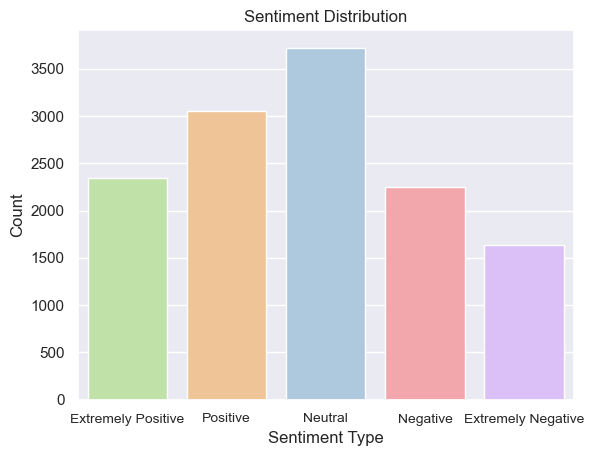

In [15]:
# Make a countplot
sns.set(style='darkgrid')
sns.countplot(data = df, 
              x = 'sentiment_label',
              order = ['Extremely Positive', 'Positive', 'Neutral', 
                       'Negative', 'Extremely Negative'], #display in a Likert scale way
              palette = ['#BEEB9F', '#FDC68A', '#A6C9E5', '#FF9AA2', '#DAB7FF'])

# Add labels and title
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.xticks(fontsize='small')

# Display the plot
plt.show()

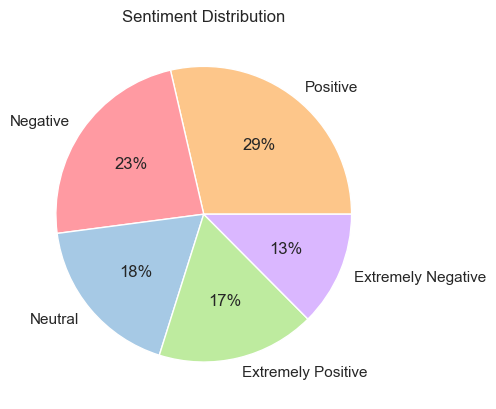

In [16]:
#generate pie chart
plt.pie(data = df,
        x = df['sentiment_label'].value_counts(),
        labels = ['Positive', 'Negative','Neutral','Extremely Positive', 
                  'Extremely Negative'], #keep consistency of labels
        colors = sns.color_palette(palette = ['#FDC68A', '#FF9AA2', '#A6C9E5', '#BEEB9F', 
                                              '#DAB7FF']), #keep consistency of colors
        autopct='%.0f%%')
plt.title('Sentiment Distribution')
plt.show()

### 2. Collocation Analysis

In [17]:
def find_collocations(text, num_collocations=10):
    # Tokenize the input text
    tokens = nltk.word_tokenize(text)
    # Create a BigramAssocMeasures object to compute the PMI scores
    bigram_measures = BigramAssocMeasures()
    # Create a BigramCollocationFinder object from the tokens
    finder = BigramCollocationFinder.from_words(tokens)
    # Apply a frequency filter to keep only bigrams that appear at least twice
    finder.apply_freq_filter(2)
    # Apply a word filter to exclude bigrams containing stopwords or punctuations
    finder.apply_word_filter(lambda w: w.lower() in stopwords.words('english') or w in string.punctuation)
    # Return the top num_collocations bigrams with the highest PMI scores
    return finder.nbest(bigram_measures.pmi, num_collocations)

In [18]:
# Apply the function to every row of clean text to a new column named 'Collocations'
df['Collocations'] = df['CleanTweet'].apply(find_collocations)
# Look at the columns that have collocations
df[df['Collocations'].apply(len) > 0]['Collocations']

45                                [(Tax, Credit)]
112                              [(good, chance)]
113                             [(toilet, paper)]
152                   [(3, extra), (extra, days)]
209                           [(first, purchase)]
                           ...                   
44372                 [(low, oil), (oil, prices)]
44438                             [(food, items)]
44547                               [(need, PPE)]
44581    [(theyÂre, going), (whether, theyÂre)]
44830                          [(everyone, else)]
Name: Collocations, Length: 522, dtype: object

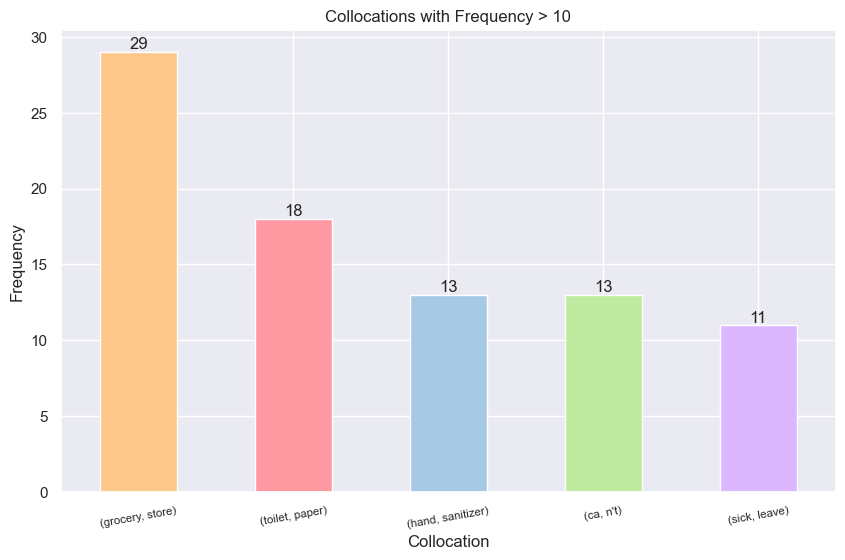

In [19]:
# Flatten the collocations column
collocations_flat = [col for sublist in df['Collocations'] for col in sublist]

# Count the frequency of each collocation
collocation_counts = pd.Series(collocations_flat).value_counts()

# Filter collocations with frequency greater than 10
filtered_collocations = collocation_counts[collocation_counts > 10]

# Create a bar chart
plt.figure(figsize=(10, 6))
ax = filtered_collocations.plot(kind='bar', 
                                color = sns.color_palette(palette = ['#FDC68A', '#FF9AA2', '#A6C9E5', '#BEEB9F', 
                                              '#DAB7FF']) )#keep consistency of colors
plt.xlabel('Collocation')
plt.ylabel('Frequency')
plt.title('Collocations with Frequency > 10')

# Add count labels on the bars
for i, v in enumerate(filtered_collocations):
    ax.text(i, v, str(v), ha='center', va='bottom')

#keep consistency of rotation, fontsize, and position the label below each bar
plt.xticks(rotation=10, fontsize='x-small', ha='center') 
    
plt.show()

## Results/Findings
[Provide text descriptions for your results/findings.]

## Extra Findings


In [20]:
# Compare our new sentiment labels with the original sentiment
accuracy_score(df['Sentiment'], df['sentiment_label'])

0.8208737117366559

_We discovered that our analyzed sentiment is 82.09% accurate compared to the original sentiment that came with the dataset. But we only focus on the new analyzed sentiment in this project._

## Contribution
[Specify each group member's contributions.]